# TRABAJO FIN DE MÁSTER. DETECCIÓN DEL CANCER DE MAMA
SOFÍA LLORENTE GARCÍA, MIQUEL CASTELLS RUBIO Y CLARA PALOMAR SEVILLANO

La base de datos utilizada cuenta con 277 524 imágenes obtenidas por WSI (Whole Slide Imaging), de las cuales 78786 son positivas de CDI (carcinoma ductal invasivo) y 198738 negativas de CDI, para poder clasificarlas. 

Las imágenes son unos parches de tamaño 50×50 que se extrajeron originalmente de 162 imágenes de diapositivas de montaje completo de muestras de cáncer de mama escaneadas a 40x.

Enlace del front: https://gitlab.com/motherai/mother-app

Enlace del back: https://gitlab.com/motherai/mother-cnn

### LIBRERÍAS Y CARGA DE DATOS

In [2]:
# Importación de las librerías que se van a utilizar

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import io
from skimage import transform
from skimage.transform import resize
import torch
import random

from sklearn.model_selection import train_test_split

import pickle

# Modelos
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

!pip install imshowtools
from imshowtools import imshow

import glob

import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Se parten las rutas de las imágenes para obtener las positivas por un lado y las negativas por otro 
#positivos = glob.glob('IDC/**/1/*.png') 
#negativos = glob.glob('IDC/**/0/*.png')

In [ ]:
# Se recorren todas las rutas y se genera un pkl para trabajar con él desde colab
#y_all = []
#x_all = []
#expected_input_shape = (50, 50, 3)
#for img_rute in positivos:
#    img = cv2.imread(img_rute)
#    if(expected_input_shape != img.shape):
#       img = transform.resize(image=img, output_shape=expected_input_shape)
#    x_all.append(img)
#    y_all.append(1)

In [ ]:
#for img_rute in negativos:
#    img = cv2.imread(img_rute)
#    if(expected_input_shape != img.shape):
#      img = transform.resize(image=img, output_shape=expected_input_shape)
#    x_all.append(img)
#    y_all.append(0)

In [ ]:
#dataset = np.array(x_all), np.array(y_all)

In [ ]:
#file = open('idc_data.pkl', 'wb') 
#pickle.dump(dataset, file)
#file.close()

In [3]:
# Semilla de cada una de las librerías e inicialización de forma que todos los números aleatorios cada vez que se use esta función, partan del mismo número
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
dpath = '/gdrive/MyDrive/IDC'

In [ ]:
#with open('idc_data.pkl', 'rb') as f:
    #data = pickle.load(f)

In [ ]:
# Se separan los datos

#X_all = data[0]
#y_all = data[1]

In [ ]:
# Balanceo mediante 'undersampling' 

#import ibmlearn
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42, replacement=True) # fit predictor and target variable
#X_all, y_all = rus.fit_resample(X_all, y_all)

#print('Resample dataset shape:', Counter(y_all))

In [ ]:
# División de los datos en train y test 

#X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size = 0.2,
#                                                     random_state = 142, shuffle = True)

In [6]:
########################################################## DATOS PEQUEÑOS

with open(f'{dpath}/train_idc_data_small_float.pkl', 'rb') as f:
    train = pickle.load(f)   

with open(f'{dpath}/test_idc_data_small_float.pkl', 'rb') as f:
    test = pickle.load(f)       

In [7]:
########################################################## DATOS PEQUEÑOS
X_train = train[0]
X_test = test[0]

y_train = train[1]
y_test = test[1]

In [8]:
########################################################## DATOS PEQUEÑOS IMAGENES
with open(f'{dpath}/test_idc_data_small.pkl', 'rb') as f:
    test_imagenes = pickle.load(f)  

In [100]:
########################################################## DATOS PEQUEÑOS IMAGENES
# Separación en positivos y negativos

negativos_x = test_imagenes[0][test_imagenes[1] == 0]
positivos_x = test_imagenes[0][test_imagenes[1] == 1]

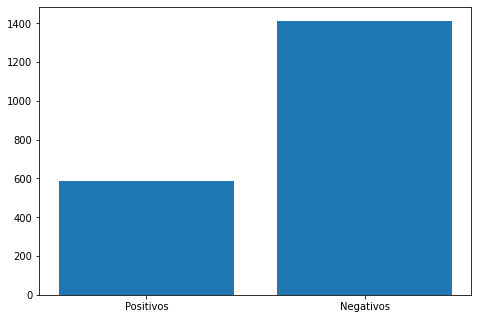

In [101]:
# Análisis exploratorio

num_pos = len(positivos_x)
num_neg = len(negativos_x)

# Verificación de que el dataset no está balanceado

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cat = ['Positivos', 'Negativos']
num = [num_pos, num_neg]
ax.bar(cat,num)
plt.show()

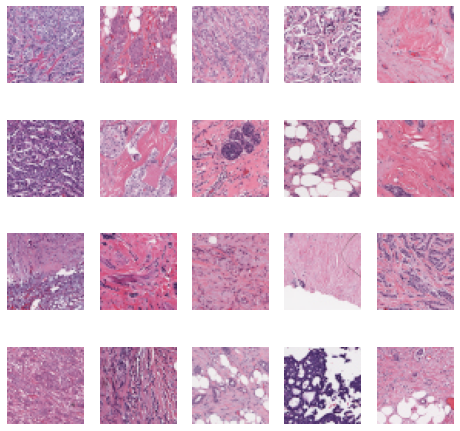

In [ ]:
# Visualización de imágenes con cáncer

imshow(*positivos_x[:20], size = (8,8))

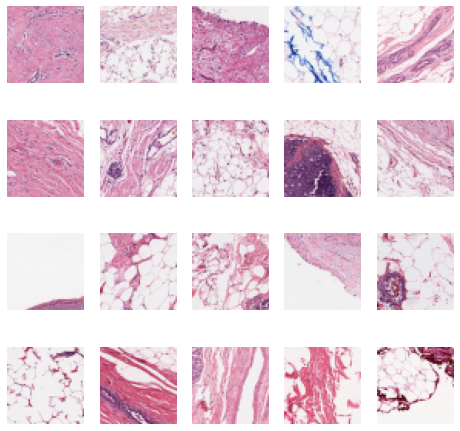

In [ ]:
# Visualización de imágenes sin cáncer

imshow(*negativos_x[:20], size = (8,8))

In [ ]:
# Número de filas y resolución del dataset
print("Número de filas del dataset en la variable X:")
print("Set de train ", "Set de test")
print(X_train.shape[0],"         ", X_test.shape[0])
print("----------")
print("Número de filas del dataset en la variable y:")
print("Set de train ", "Set de test")
print(y_train.shape[0],"       ", y_test.shape[0])
print("----------")
print("La resolución de las imagenes del set de training y de testing es", X_train.shape[1], "x", X_train.shape[2], "con", X_train.shape[3], "canales")

Número de filas del dataset en la variable X:
Set de train  Set de test
10000           2000
----------
Número de filas del dataset en la variable y:
Set de train  Set de test
10000         2000
----------
La resolución de las imagenes del set de training y de testing es 50 x 50 con 3 canales


In [ ]:
# Mínimos y máximos
print("Los valores de los píxeles de la imagen 134 se encuentran en el rango:", (np.min(X_test[134]), np.max(X_test[134])))

Los valores de los píxeles de la imagen 134 se encuentran en el rango: (47.0, 248.0)


In [ ]:
print("Los valores de los píxeles de la imagen 14 se encuentran en el rango:", (np.min(X_test[14]), np.max(X_test[14])))

Los valores de los píxeles de la imagen 14 se encuentran en el rango: (21.0, 244.0)


Cada imagen tiene unos mínimos y máximos diferentes, por esto hay que reescalar las imágenes

### PROCESADO DE LAS IMÁGENES
Es importante mantener los colores y es interesante observar si potenciando el contraste se predice mejor

In [9]:
# Función para el reescalado de las imágenes

def reescalar(nparray): 
  n = len(nparray)
  i = 0
  expected_input_shape = (48, 48, 3) # Cambio en la resolución
  nparray_resized = [] 
  for i in range(n):
    img = transform.resize(image=nparray[i], output_shape=expected_input_shape)
    nparray_resized.append(img)
    nparray_resized[i] = nparray_resized[i] / (np.max(nparray_resized[i]) - np.min(nparray_resized[i])) - 0.5 # División de cada elemento entre la variación de sus pixeles
    i += 1
  return np.array(nparray_resized)

In [10]:
# Función para aplanar las imágenes

def flatten(nparray):
    nparray = (nparray.reshape(nparray.shape[0], -1) / 255.0) * 2.0 - 1.0 
    return nparray

In [11]:
# Reescalado de las imagenes para tener los valores entre -0.5 y 0.5

X_train_n = reescalar(X_train)
X_test_n = reescalar(X_test)

In [12]:
# Imágenes aplanadas en un solo vector para los modelos de machine learning

X_train_n_ml = flatten(X_train_n)
X_test_n_ml = flatten(X_test_n)

### MODELOS ML
Se evalúan los siguientes modelos de ML 
- KNN
- Linear SVC
- Decision tree
- Logistic regression
- Random Forest
- Gradient Boosting


In [13]:
# Comprobación de que todos los arrays tengan la misma forma

def areSame(a, n):
    i = 0
    for i in range(n):
      if(a.shape[i] == a.shape[i]):
          return True
          i = 1 + 1
      else:
          return False
  

if __name__ == '__main__':
     
    n = len(X_train)
     
    if(areSame(X_train, n)):
        print("All elements are same size")
    else:
        print("Not all elements are same size")
if __name__ == '__main__':
     
    n = len(y_train)
     
    if(areSame(y_train, n)):
        print("All elements are same size")
    else:
        print("Not all elements are same size")

All elements are same size
All elements are same size


In [14]:
# Modelo DecisionTree

dec = DecisionTreeClassifier(random_state = 123)
dec.fit(X = X_train_n_ml, y = y_train)

DecisionTreeClassifier(random_state=123)

In [16]:
# Modelo RandomForest

rf = RandomForestClassifier(n_estimators = 200, random_state = 123)
rf.fit(X = X_train_n_ml, y = y_train)

RandomForestClassifier(n_estimators=200, random_state=123)

In [17]:
# Modelo LogisticRegression ##

lg = LogisticRegression(random_state = 123, max_iter = 400)
lg.fit(X = X_train_n_ml, y = y_train)

LogisticRegression(max_iter=400, random_state=123)

In [18]:
# Modelo KNeighbors

KN = KNeighborsClassifier()
KN.fit(X = X_train_n_ml, y = y_train)

KNeighborsClassifier()

In [15]:
# Modelo GradientBoosting

gradient_class = GradientBoostingClassifier(random_state = 123)
gradient_class.fit(X = X_train_n_ml, y = y_train)

GradientBoostingClassifier(random_state=123)

In [19]:
# Modelo LinearSVC

ls = svm.LinearSVC()
ls.fit(X = X_train_n_ml, y = y_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [20]:
# Resultados de los modelos (accuracy)

train_dec = (dec.score(X = X_train_n_ml, y = y_train))
test_dec = (dec.score(X = X_test_n_ml, y = y_test))

train_rf = (rf.score(X = X_train_n_ml, y = y_train))
test_rf = (rf.score(X = X_test_n_ml, y = y_test))

train_lg =  (lg.score(X = X_train_n_ml, y = y_train))
test_lg = (lg.score(X = X_test_n_ml, y = y_test))

train_KN = (KN.score(X = X_train_n_ml, y = y_train))
test_KN = (KN.score(X = X_test_n_ml, y = y_test))

train_gb = (gradient_class.score(X = X_train_n_ml, y = y_train))
test_gb =  (gradient_class.score(X = X_test_n_ml, y = y_test))

train_ls = (ls.score(X = X_train_n_ml, y = y_train))
test_ls = (ls.score(X = X_test_n_ml, y = y_test))

In [21]:
print("Resultados del modelo DecisionTree:")
print("Score de training set:", train_dec)
print("Score de testing set:", test_dec)
print(" ")

print("Resultados del modelo RandomForest:")
print("Score de training set:", train_rf)
print("Score de testing set:", test_rf)
print(" ")

print("Resultados del modelo LogisticRegression:")
print("Score de training set:", train_lg)
print("Score de testing set:", test_lg)
print(" ")

print("Resultados del modelo KNeighbors:")
print("Score de training set:", train_KN)
print("Score de testing set:", test_KN)
print(" ")

#print("Resultados del modelo GradientBoostingClassifier:")
#print("Score de training set:", train_gb)
#print("Score de testing set:", test_gb)
#print(" ")

print("Resultados del modelo LinearSVC:")
print("Score de training set:", train_ls)
print("Score de testing set:", test_ls)
print(" ")

Resultados del modelo DecisionTree:
Score de training set: 1.0
Score de testing set: 0.7235
 
Resultados del modelo RandomForest:
Score de training set: 1.0
Score de testing set: 0.822
 
Resultados del modelo LogisticRegression:
Score de training set: 0.7327
Score de testing set: 0.7295
 
Resultados del modelo KNeighbors:
Score de training set: 0.8202
Score de testing set: 0.774
 
Resultados del modelo LinearSVC:
Score de training set: 0.2863
Score de testing set: 0.293
 


### MODELOS DE DEEP LEARNING

1.  



#### RED NEURONAL NO CONVOLUCIONAL

In [22]:
# Cargar de las variables como tensores de Pytorch

tX_train_nn1 = torch.tensor(X_train_n, requires_grad = False, dtype = torch.float)
tX_test_nn1 = torch.tensor(X_test_n, requires_grad = False, dtype = torch.float)
ty_train_nn1 = torch.tensor(y_train, requires_grad = False, dtype = torch.long)  
ty_test_nn1 = torch.tensor(y_test, requires_grad = False, dtype = torch.long)

Se implementa una red neuronal que dada una imagen devuelva la probabilidad de que la imagen pertenezca a cada categoría posible (positivo o negativo). La capa de input tiene tantos elementos como valores haya en cada imagen (48 x 48 x 3 = 6912) y la capa de output tiene 2 elementos, positivo o negativo. Para que forward pass pueda aceptar los datos, el siguiente paso es "aplanar" los tensores de forma que los píxeles se organicen en una única dimensión de 6912 elementos.

In [23]:
# Dimensiones imagen entrada de las redes

high = X_train_n.shape[1]
weight = X_train_n.shape[2]
dimensiones = X_train_n.shape[3]
total_pix = (high * weight) * dimensiones

In [24]:
# Se aplanan las imágenes

tX_train_l = tX_train_nn1.view(tX_train_nn1.shape[0], total_pix)
tX_test_l = tX_test_nn1.view(tX_test_nn1.shape[0], total_pix)

In [25]:
# Se implementa "forward pass" para facilitar la implementación de la red

# Módulo lineal
linear_1 = torch.nn.Linear(2,5) # una capa lineal de 2 unidades de entrada y 5 unidades de salida
linear_1

Linear(in_features=2, out_features=5, bias=True)

In [26]:
# Forward pass de un modelo
linear_1(tX_train_l[0:4, :2])

tensor([[ 0.0215, -1.0240, -0.8153, -0.1265, -0.2328],
        [ 0.0950, -1.2333, -0.8282, -0.0190, -0.2077],
        [ 0.2440, -1.4963, -0.7807,  0.2005, -0.1402],
        [-0.0632, -0.9352, -0.8702, -0.2520, -0.2774]],
       grad_fn=<AddmmBackward0>)

In [27]:
# Red neuronal no convolucional

nn1 = torch.nn.Sequential(
    torch.nn.Linear(48 * 48 * 3, 256), # capa lineal con 7500 entradas y 256 salidas
    torch.nn.ReLU(),  # activación ReLU
    torch.nn.Linear(256, 2), # capa lineal con 256 entradas y 2 salidas
    torch.nn.LogSoftmax(dim = 1) # El output es la probabilidad de pertenencia a cada categoría
)

In [28]:
# Se transladan los tensores y 'modules' a la GPU

nn1 = nn1.cuda()
tX_train_l = tX_train_l.cuda()
tX_test_l = tX_test_l.cuda()
tX_train_nn1 = tX_train_nn1.cuda()
tX_test_nn1 = tX_test_nn1.cuda()
ty_train_nn1 = ty_train_nn1.cuda()
ty_test_nn1 = ty_test_nn1.cuda()

In [29]:
# Inicialización de los pesos con xavier (usa distribuciones diferentes para cada capa)
# De esta forma, los valores de las activciones en cada neurona están en rangos aceptables, independientemente del número de inputs

def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [30]:
do_seeds(29) # Fijar la semilla aleatoria 
init_f(nn1) # Inicialización de los pesos

In [31]:
# Al tratarse de un problema de clasificación, se utiliza la función NLLLoss

def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y) # Recibe lo que sale del modelo y las etiquetas reales

In [32]:
loss_f(tX_train_l, ty_train_nn1, nn1) # Devuelve un tensor con su gradiente

tensor(1.8640, device='cuda:0', grad_fn=<NllLossBackward0>)

In [33]:
# Predicciones a partir del output del forward pass

def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

In [34]:
# Porcentaje de aciertos

def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

In [35]:
print(score_f(tX_train_l, ty_train_nn1, nn1))
print(score_f(tX_test_l, ty_test_nn1, nn1))

0.2862
0.2935


##### ENTRENAMIENTO RED NEURONAL NO CONVOLUCIONAL

In [36]:
 # Función que de un paso en el entrenamiento

def t_step(x, y, forw, opt):
   opt.zero_grad() # Se resetean los valores acumulados de las derivadas
   loss = loss_f(x, y, forw) # Se calcula la 'loss' con los resultados 
   out = loss.item() # Se almacena el valor de loss para devolverlo como resultado intermedio
   loss.backward() # Se propagan las derivadas de la 'loss' con respecto a nuestros parámetros
   opt.step() # Se ejecuta un paso del optimizador
   return out

In [37]:
opt1 = torch.optim.SGD(nn1.parameters(), lr = 0.0025)

In [38]:
# Entrenamiento

for i in range(500):
    out = t_step(tX_train_l, ty_train_nn1, nn1, opt1)
    if i%250 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))

Epoch: 0, Loss: 1.8640
Epoch: 250, Loss: 0.4569


In [39]:
# Resultados de la red no convolucional

train_nn1 = score_f(tX_train_l, ty_train_nn1, nn1)
test_nn1 = score_f(tX_test_l, ty_test_nn1, nn1)
print("Resultado de la red no convolucional para el set de training:", train_nn1)
print("Resultado de la red no convolucional para el set de testing:", test_nn1)

Resultado de la red no convolucional para el set de training: 0.808
Resultado de la red no convolucional para el set de testing: 0.8105


#### RED NEURONAL CONVOLUCIONAL

In [40]:
# Creación de los nuevos tensores para la red convolucional

tX_train_nn2 = torch.tensor(X_train_n, requires_grad = False, dtype = torch.float)
tX_test_nn2 = torch.tensor(X_test_n, requires_grad = False, dtype = torch.float)
ty_train_nn2 = torch.tensor(y_train, requires_grad = False, dtype = torch.long)  
ty_test_nn2 = torch.tensor(y_test, requires_grad = False, dtype = torch.long)  

In [41]:
print(tX_train_nn2.shape)

torch.Size([10000, 48, 48, 3])


In [42]:
# Ejecución en GPU

tX_train_nn2 = tX_train_nn2.cuda()
tX_test_nn2 = tX_test_nn2.cuda()
ty_train_nn2 = ty_train_nn2.cuda()
ty_test_nn2 = ty_test_nn2.cuda()

In [43]:
# Red neuronal convolucional

def build_nn2():
  nn2 = torch.nn.Sequential(
      #48*48*3
      torch.nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 2),
      #50*50*32
      torch.nn.MaxPool2d(2),
      #25*25*32
      torch.nn.LeakyReLU(),
    
      torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 2),
      #27*27*64
      torch.nn.MaxPool2d(2),
      #27*27*64
      torch.nn.LeakyReLU(),

      torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 2),
      #15*15*128
      torch.nn.MaxPool2d(2),
      #7*7*128
      torch.nn.LeakyReLU(),
      torch.nn.Dropout(p = 0.25), # Evita overfitting

      torch.nn.Flatten(),
      torch.nn.Linear(6272, 3136), 
      torch.nn.LeakyReLU(),
      torch.nn.Dropout(p = 0.25),

      torch.nn.Linear(3136, 2),
      torch.nn.LogSoftmax() 
    )
  return nn2

In [44]:
# Ejecución en GPU
nn2 = build_nn2()
nn2 = nn2.cuda()

In [45]:
# Resumen del modelo

from torchvision import models
from torchsummary import summary

summary(nn2, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             896
         MaxPool2d-2           [-1, 32, 25, 25]               0
         LeakyReLU-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 64, 27, 27]          18,496
         MaxPool2d-5           [-1, 64, 13, 13]               0
         LeakyReLU-6           [-1, 64, 13, 13]               0
            Conv2d-7          [-1, 128, 15, 15]          73,856
         MaxPool2d-8            [-1, 128, 7, 7]               0
         LeakyReLU-9            [-1, 128, 7, 7]               0
          Dropout-10            [-1, 128, 7, 7]               0
          Flatten-11                 [-1, 6272]               0
           Linear-12                 [-1, 3136]      19,672,128
        LeakyReLU-13                 [-1, 3136]               0
          Dropout-14                 [-

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [46]:
# Parámetros del modelo ##

print("El modelo tiene", np.sum([np.prod(p.shape) for p in nn2.parameters()]), "parámetros")

El modelo tiene 19771650 parámetros


##### ENTRENAMIENTO RED NEURONAL CONVOLUCIONAL

In [47]:
do_seeds(29) # Fijar semilla aleatoria ##
init_f(nn2) # Inicialización de los pesos

In [48]:
# Optimizador Adam

opt2 = torch.optim.Adam(nn2.parameters(), weight_decay = 0.008, lr = 0.0002)

In [49]:
# Colocar los canales en segunda posición

tX_train_nn2 = tX_train_nn2.permute(0, 3, 1, 2)
tX_test_nn2 = tX_test_nn2.permute(0, 3, 1, 2)
tX_train_nn2.shape

torch.Size([10000, 3, 48, 48])

In [50]:
# Creación de una minibatch

mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train_nn2, ty_train_nn2),
                                     batch_size = 100, shuffle = True)

In [51]:
# Entrenamiento

for i in range(500):
  for x_j, y_j  in mini_b:
    out = t_step(x_j, y_j, nn2, opt2)
  if i%100 == 0:
    print("Epoch: {}, Loss {:.4f}".format(i, out))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0, Loss 0.2872
Epoch: 100, Loss 0.3310
Epoch: 200, Loss 0.3069
Epoch: 300, Loss 0.2641
Epoch: 400, Loss 0.3492


In [52]:
# Resultados de la red convolucional

train_nn2 = score_f(tX_train_nn2, ty_train_nn2, nn2)
test_nn2 = score_f(tX_test_nn2, ty_test_nn2, nn2)
print("Resultado de la red convolucional para el set de training:", train_nn2)
print("Resultado de la red convolucional para el set de testing:", test_nn2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Resultado de la red convolucional para el set de training: 0.8521
Resultado de la red convolucional para el set de testing: 0.8485


In [ ]:
#### GUARDADO Y CARGA DEL MODELO CNN ENTRENADO #####

In [ ]:
# torch.save(nn2.state_dict(), 'sequential_idc.pt')

In [ ]:
# with open(f'{dpath}/sequential_idc.pt', 'rb') as f:
    # nn2_state_dict = torch.load(f)  

In [ ]:
#nn2 = build_nn2()

In [ ]:
#nn2 = nn2.load_state_dict(nn2_state_dict)

In [ ]:
#nn2 = nn2.eval()

In [ ]:
#sample = X_test_n[0]

In [ ]:
#sample = sample.transpose(2, 0, 1)[np.newaxis,:,:,:]

In [ ]:
#tX_test_nn2_sample = torch.tensor(sample, requires_grad = False, dtype = torch.float)

In [ ]:
#predict_sample = pred_f(tX_test_nn2_sample, nn2)[0]

In [ ]:
#predict_sample.item()

In [ ]:
# nn2 = nn2.cuda()

In [ ]:
# Resultados de la red convolucional
# test_nn2 = score_f(tX_test_nn2, ty_test_nn2, nn2)
# print("Resultado de la red convolucional para el set de testing:", test_nn2)

In [ ]:
# Matriz nn2
# pred_nn2 = pred_f(tX_test_nn2, nn2)
# matriz_conf_nn2 = confusion_matrix(ty_test_nn2.tolist(), pred_nn2.tolist(), labels = list(range(2)))
# pd.DataFrame(matriz_conf_nn2, index = list(range(2)), columns = list(range(2)))

In [ ]:
#### FIN GUARDADO Y CARGA DEL MODELO CNN ENTRENADO #####

In [ ]:
# Probabilidad de que sea CDI en la propia imagen

In [ ]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()   
    
    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [ ]:
run_training = False
LOSSES_PATH = "../input/breastcancermodel/"

if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.patient_id.unique()[n]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="YlOrRd")

    for m in range(3):
        ax[n, m].set_xlabel("y-coord")
        ax[n, m].set_ylabel("x-coord")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");

### COMPARACIÓN DE MODELOS

In [53]:
# Matriz DecisionTree
matriz_conf_dec = confusion_matrix(y_test, dec.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_dec, index = list(range(2)), columns = list(range(2)))

0    1
0  1145  269
1   284  302

In [54]:
# Matriz KNeighbors
matriz_conf_KN = confusion_matrix(y_test, KN.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_KN, index = list(range(2)), columns = list(range(2)))

0    1
0  1264  150
1   302  284

In [55]:
# Matriz LogisticRegression
matriz_conf_LG = confusion_matrix(y_test, lg.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_LG, index = list(range(2)), columns = list(range(2)))

0   1
0  1403  11
1   530  56

In [56]:
# Matriz RandomForest
matriz_conf_RF = confusion_matrix(y_test, rf.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_RF, index = list(range(2)), columns = list(range(2)))

0    1
0  1359   55
1   301  285

In [57]:
# Matriz GradientBoosting
matriz_conf_GB = confusion_matrix(y_test, gradient_class.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_GB, index = list(range(2)), columns = list(range(2)))

0    1
0  1332   82
1   290  296

In [58]:
# Matriz LinearSVC
matriz_conf_LS = confusion_matrix(y_test, ls.predict(X_test_n_ml), labels = list(range(2)))
pd.DataFrame(matriz_conf_LS, index = list(range(2)), columns = list(range(2)))

0     1
0  0  1414
1  0   586

In [59]:
# Matriz nn1
pred_nn1 = pred_f(tX_test_l, nn1)
matriz_conf_nn1 = confusion_matrix(ty_test_nn1.tolist(), pred_nn1.tolist(), labels = list(range(2)))
pd.DataFrame(matriz_conf_nn1, index = list(range(2)), columns = list(range(2)))

0    1
0  1321   93
1   286  300

In [60]:
# Matriz nn2
pred_nn2 = pred_f(tX_test_nn2, nn2)
matriz_conf_nn2 = confusion_matrix(ty_test_nn2.tolist(), pred_nn2.tolist(), labels = list(range(2)))
pd.DataFrame(matriz_conf_nn2, index = list(range(2)), columns = list(range(2)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0    1
0  1325   89
1   217  369

In [61]:
# Comparación de los valores de accuracy en cada modelo

comparacion = pd.DataFrame()

# Columnas
comparacion['DecisionTree'] = None
comparacion['RandomForest'] = None
comparacion['LogisticRegression'] = None
comparacion['KNeighbors'] = None
comparacion['GradientBoosting'] = None
comparacion['LinearSVC'] = None
comparacion['Red No Convolucional'] = None
comparacion['Red Convolucional'] = None

# Filas
comparacion.loc['Train'] = (train_dec, train_rf, train_lg, train_KN, train_gb, train_ls, train_nn1, train_nn2)
comparacion.loc['Test'] = [test_dec, test_rf, test_lg, test_KN, test_gb, test_ls, test_nn1, test_nn2]

print("RESULTADOS DE LOS MODELOS ENTRENADOS")
print(comparacion)

RESULTADOS DE LOS MODELOS ENTRENADOS
       DecisionTree  RandomForest  LogisticRegression  KNeighbors  \
Train        1.0000         1.000              0.7327      0.8202   
Test         0.7235         0.822              0.7295      0.7740   

       GradientBoosting  LinearSVC  Red No Convolucional  Red Convolucional  
Train            0.8725     0.2863                0.8080             0.8521  
Test             0.8140     0.2930                0.8105             0.8485  


Una vez entrenados todos los modelos y vistos sus resultados, el modelo que mejor valor obtiene es la red convolucional, lo cual se esperaba antes de realizar el estudio.


### COMPARATIVA DE LA ROBUSTEZ DE LOS MODELOS
Se prueba el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing, como por ejemplo sobre translaciones horizontales

Una de las ventajas mas importantes de las redes convolucionales frente a las no convolucionales en la clasificación de imágenes es que son robustas ante traslaciones de las imágenes de entrada

In [63]:
x_test_Ws = test_imagenes[0][:100]
y_test_Ws = test_imagenes[1][:100]

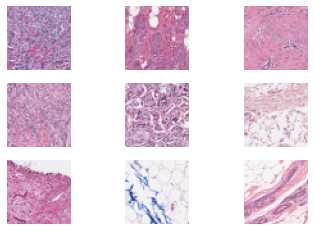

In [64]:
imshow(*x_test_Ws[:9])

In [81]:
rotations = []
rotations_y = []

In [82]:
for i in range(100):
    original = x_test_Ws[i]
    original_y = y_test_Ws[i]
    rotations.append(original)
    rotations_y.append(original_y)
    rot90 = np.rot90(original)
    rotations.append(rot90)
    rotations_y.append(original_y)
    rot180 =  np.rot90(rot90)
    rotations.append(rot180)
    rotations_y.append(original_y)
    rot270 =  np.rot90(rot180)
    rotations.append(rot270)
    rotations_y.append(original_y)

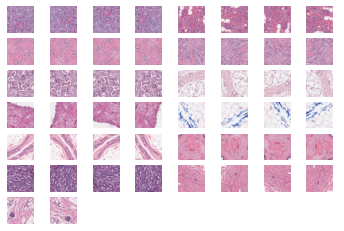

In [83]:
imshow(*rotations[:50])

In [84]:
rotations_n = reescalar(rotations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [85]:
tensors_y = torch.tensor(rotations_y, requires_grad = False, dtype = torch.long).cuda()

In [86]:
rotations_n.shape

(400, 48, 48, 3)

In [87]:
high = rotations_n.shape[1]
weight = rotations_n.shape[2]
dimensiones = rotations_n.shape[3]
total_pix = (high * weight) * dimensiones

In [88]:
nn1_scores = []

In [89]:
nn1.eval()

Sequential(
  (0): Linear(in_features=6912, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)

In [90]:
for image in rotations_n:
  image = image.transpose(0, 1, 2)[np.newaxis,:,:,:]
  tensor_x = torch.tensor(image, requires_grad = False, dtype = torch.float).cuda()
  tensor_x_l = tensor_x.view(tensor_x.shape[0], total_pix)
  score = score_f(tensor_x_l, tensors_y, nn1)
  nn1_scores.append(score)

In [91]:
nn2_scores = []

In [92]:
nn2.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Dropout(p=0.25, inplace=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=6272, out_features=3136, bias=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=3136, out_features=2, bias=True)
  (15): LogSoftmax(dim=None)
)

In [93]:
rotations_n_nn2 = np.transpose(rotations_n,[0,3,1,2])

In [94]:
for image in rotations_n_nn2:
  image = image.transpose(0, 1, 2)[np.newaxis,:,:,:]
  tensor_x = torch.tensor(image, requires_grad = False, dtype = torch.float).cuda()
  score = score_f(tensor_x, tensors_y, nn2)
  nn2_scores.append(score)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [95]:
print(len(nn1_scores))
print(len(nn2_scores))

400
400


In [96]:
all_scores = pd.DataFrame(data = {
    'nn1': nn1_scores,
    'nn2': nn2_scores
})

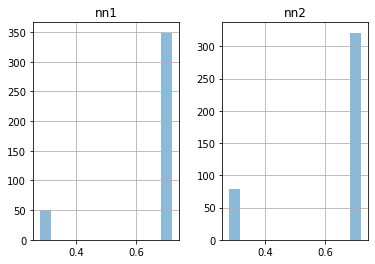

In [104]:
all_scores.hist(bins=12, alpha=0.5);

En el plot podemos comprobar como la nn2 a fallado menos que la nn1, por lo tanto, La red convolutional resiste mejor la rotación de imágenes.
